# SUDO CODE 2025

- Name: Nguyễn Anh Đức
- Team: 9
- ID: 28

## Import libs

In [1]:
import json
import zipfile
import pandas as pd
import numpy as np
import re
import requests
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

## *vietnamese text classification dataset*

## Exploring data

### Read rawdata from file

In [2]:
df1 = pd.read_csv("data/vietnamese-text-classification-dataset/train.csv", header=None, names=['label', 'text'])

In [3]:
df1.head()

,label,text
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng


### Number of rows and columns

In [4]:
shape = df1.shape
print(shape)

(3040, 2)


### Check duplicate rows

In [5]:
num_duplicated_rows = df1.duplicated().sum()
print(num_duplicated_rows)

40


### Remove empty data

In [6]:
df1 = df1.dropna() 
df1 = df1[~df1.eq('').any(axis=1)]
df1 = df1.reset_index(drop=True)

In [7]:
print(df1.shape)

(3040, 2)


### Label count

In [8]:
label_counts = df1['label'].value_counts()
label_counts

label
0    1105
2    1048
1     887
Name: count, dtype: int64

## Preprocessing data

### Lowercase the content

In [9]:
df1["text"] = df1["text"].str.lower()
df1['text'].head()

0                               máy dùng hay bị đơ máy
1    chỉ có dây cáp nguồn không có adapter sao sử d...
2    chất lượng quá kém mới dùng được 2 ngày loa ba...
3    usb tôi vừa mới nhận usb này rất bực bội vì cá...
4                         tuyệt vời. hàng fpt cửa hàng
Name: text, dtype: object

### Remove punctuation

In [10]:
df1['text'] = df1['text'].apply(lambda t: re.sub(r'[^\w\s]', ' ', t, flags=re.UNICODE))

### Remove number

In [11]:
df1['text'] = df1['text'].apply(lambda t: re.sub(r'\d+', ' ', t, flags=re.UNICODE))
df1['text'] = df1['text'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Remove special symbols

In [12]:
df1['text'] = df1['text'].apply(lambda t: re.sub(r'[^a-zA-ZÀ-ỹ\s]', ' ', t, flags=re.UNICODE))
df1['text'] = df1['text'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Collapse multiple whitespaces and strip

In [13]:
df1['text'] = df1['text'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Drop rows that became empty after cleaning and reindex

In [14]:
df1 = df1[df1['text'].str.strip() != ''].reset_index(drop=True)
df1.shape

(3040, 2)

## Tokenization

In [15]:
df1['tokens'] = df1['text'].apply(lambda x: word_tokenize(x))
df1[['text', 'tokens']].head()

,text,tokens
0,máy dùng hay bị đơ máy,"[máy, dùng, hay, bị, đơ, máy]"
1,chỉ có dây cáp nguồn không có adapter sao sử d...,"[chỉ, có, dây, cáp, nguồn, không, có, adapter,..."
2,chất lượng quá kém mới dùng được ngày loa bass...,"[chất, lượng, quá, kém, mới, dùng, được, ngày,..."
3,usb tôi vừa mới nhận usb này rất bực bội vì cá...,"[usb, tôi, vừa, mới, nhận, usb, này, rất, bực,..."
4,tuyệt vời hàng fpt cửa hàng,"[tuyệt, vời, hàng, fpt, cửa, hàng]"


## Stopword removal

In [16]:
url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
response = requests.get(url)
vi_stopwords = set(response.text.splitlines())

print("Number of stopwords:", len(vi_stopwords))
print(list(vi_stopwords)[:10])

Number of stopwords: 1942
['vừa rồi', 'bỏ không', 'đánh giá', 'tên chính', 'có dễ', 'nhé', 'giờ đến', 'chẳng nữa', 'thế', 'tuy']


In [17]:
def remove_stopwords_vi(tokens, stopwords_set):
    return [word for word in tokens if word not in stopwords_set]

df1['tokens_no_stop'] = df1['tokens'].apply(lambda x: remove_stopwords_vi(x, vi_stopwords))
df1[['tokens', 'tokens_no_stop']].head()

,tokens,tokens_no_stop
0,"[máy, dùng, hay, bị, đơ, máy]","[máy, đơ, máy]"
1,"[chỉ, có, dây, cáp, nguồn, không, có, adapter,...","[dây, cáp, adapter, sử, dụng, dây, cáp, adapte..."
2,"[chất, lượng, quá, kém, mới, dùng, được, ngày,...","[chất, kém, loa, bass, âm, rè, rè, tưởng, chất]"
3,"[usb, tôi, vừa, mới, nhận, usb, này, rất, bực,...","[usb, usb, bực, bội, nắp, usb, cứng, thể, hộp,..."
4,"[tuyệt, vời, hàng, fpt, cửa, hàng]","[tuyệt, vời, hàng, fpt, cửa, hàng]"


In [18]:
df1['text_no_stop'] = df1['tokens_no_stop'].apply(lambda x: " ".join(x))

## Train/Test Split

In [19]:
X = df1['text_no_stop']
y = df1['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Extraction

### Bag-of-Words

In [20]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("Shape of BOW matrix:", X_train_bow.shape)
print("First 10 BOW features:", list(bow_vectorizer.get_feature_names_out())[:10])

Shape of BOW matrix: (2432, 2317)
First 10 BOW features: ['aa', 'abc', 'ac', 'ace', 'active', 'ad', 'adapter', 'admin', 'ads', 'advance']


### TF-IDF

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix:", X_train_tfidf.shape)
print("First 10 TF-IDF features:", list(tfidf_vectorizer.get_feature_names_out())[:10])

Shape of TF-IDF matrix: (2432, 2317)
First 10 TF-IDF features: ['aa', 'abc', 'ac', 'ace', 'active', 'ad', 'adapter', 'admin', 'ads', 'advance']


## Training and Evaluating

### BoW + Naive Bayes

In [22]:
results = {}
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred = nb_bow.predict(X_test_bow)
results["BoW + NB"] = accuracy_score(y_test, y_pred)
print("=== BoW + Naive Bayes ===")
print(classification_report(y_test, y_pred))

=== BoW + Naive Bayes ===
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       221
           1       0.64      0.52      0.57       177
           2       0.75      0.81      0.78       210

    accuracy                           0.72       608
   macro avg       0.71      0.71      0.70       608
weighted avg       0.71      0.72      0.71       608



### BoW + SVM

In [23]:
svm_bow = LinearSVC()
svm_bow.fit(X_train_bow, y_train)
y_pred = svm_bow.predict(X_test_bow)
results["BoW + SVM"] = accuracy_score(y_test, y_pred)
print("=== BoW + SVM ===")
print(classification_report(y_test, y_pred))

=== BoW + SVM ===
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       221
           1       0.60      0.55      0.57       177
           2       0.77      0.74      0.75       210

    accuracy                           0.69       608
   macro avg       0.69      0.69      0.69       608
weighted avg       0.69      0.69      0.69       608



### TF-IDF + Naive Bayes

In [24]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred = nb_tfidf.predict(X_test_tfidf)
results["TF-IDF + NB"] = accuracy_score(y_test, y_pred)
print("=== TF-IDF + Naive Bayes ===")
print(classification_report(y_test, y_pred))

=== TF-IDF + Naive Bayes ===
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       221
           1       0.68      0.41      0.51       177
           2       0.74      0.85      0.79       210

    accuracy                           0.71       608
   macro avg       0.71      0.69      0.69       608
weighted avg       0.71      0.71      0.70       608



### TF-IDF + SVM

In [25]:
svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred = svm_tfidf.predict(X_test_tfidf)
results["TF-IDF + SVM"] = accuracy_score(y_test, y_pred)
print("=== TF-IDF + SVM ===")
print(classification_report(y_test, y_pred))

=== TF-IDF + SVM ===
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       221
           1       0.66      0.54      0.60       177
           2       0.80      0.82      0.81       210

    accuracy                           0.73       608
   macro avg       0.72      0.72      0.72       608
weighted avg       0.72      0.73      0.72       608



## Result Visualization

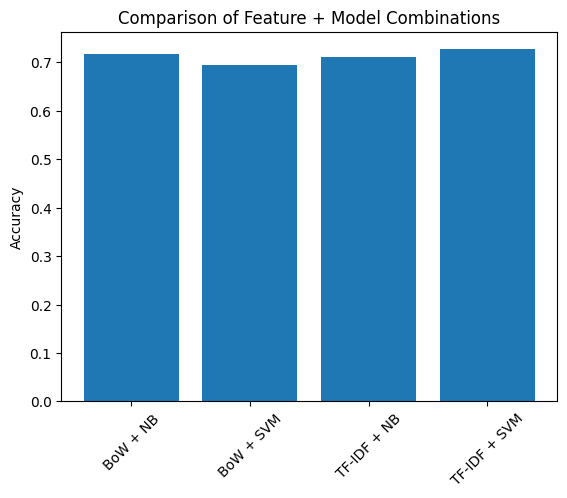

In [26]:
plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy")
plt.title("Comparison of Feature + Model Combinations")
plt.xticks(rotation=45)
plt.show()

## *UIT-ViSFD*

## Exploring data

### Read raw data from file

In [27]:
zip_file_path = 'data/UIT-ViSFD/UIT-ViSFD.zip'
extraction_path = 'data/UIT-ViSFD'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [28]:
df_train = pd.read_csv("data/UIT-ViSFD/Train.csv")
df_dev = pd.read_csv("data/UIT-ViSFD/Dev.csv")
df_test = pd.read_csv("data/UIT-ViSFD/Test.csv")

### Concate dev and test

In [29]:
df_test_concat = pd.concat([df_dev, df_test], ignore_index=True)
print(len(df_test_concat))
df_test_concat.head()

3336


,index,comment,n_star,date_time,label
0,0,"Máy ok, k chê điểm nào, chính thức là fans ViV...",5,9/7/2020,{GENERAL#Positive};{SER&ACC#Positive};
1,1,"Mới sài được 3 ngày sản phẩm thì khá là ok , l...",5,4/5/2020,{CAMERA#Positive};{FEATURES#Negative};{BATTERY...
2,2,Dùng tốt chơi game bao mượt không nóng như lời...,5,14/12/2019,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...
3,3,"Có ai giống mh kg, mh mua ip 7 plus , mấy bị h...",3,7/3/2019,{DESIGN#Negative};{OTHERS};
4,4,Ko bjk ngày mai có ra đổi đc ko đây. Mới mua h...,2,29/03/2020,{PERFORMANCE#Negative};{OTHERS};


In [30]:
df_train = df_train.drop(['index'], axis=1)
df_test_concat = df_test_concat.drop(['index'], axis=1)

### Number of rows and columns

In [31]:
print(df_train.shape)
print(df_test_concat.shape)

(7786, 4)
(3336, 4)


### Check duplicate rows

In [32]:
num_duplicated_rows = df_train.duplicated().sum()
print(num_duplicated_rows)

0


### Remove empty data

In [33]:
df_train = df_train.dropna() 
df_train = df_train[~df_train.eq('').any(axis=1)]
df_train = df_train.reset_index(drop=True)

df_test_concat = df_test_concat.dropna() 
df_test_concat = df_test_concat[~df_test_concat.eq('').any(axis=1)]
df_test_concat = df_test_concat.reset_index(drop=True)

In [34]:
print(df_train.shape)
print(df_test_concat.shape)

(7786, 4)
(3336, 4)


### Label count

In [35]:
label_counts = df_train['label'].value_counts()
label_counts

label
{FEATURES#Negative};                                                                                 141
{PERFORMANCE#Negative};                                                                              120
{BATTERY#Negative};                                                                                  119
{OTHERS};                                                                                            115
{GENERAL#Positive};{SER&ACC#Positive};                                                                86
                                                                                                    ... 
{CAMERA#Negative};{BATTERY#Negative};{PERFORMANCE#Positive};{GENERAL#Neutral};{SER&ACC#Negative};      1
{SCREEN#Negative};{FEATURES#Negative};{GENERAL#Negative};{SER&ACC#Positive};                           1
{DESIGN#Neutral};{GENERAL#Negative};                                                                   1
{CAMERA#Positive};{FEATURES#Negative};{BATTERY#Po

## Preprocessing data

### Lowercase the content

In [36]:
df_train["comment"] = df_train["comment"].str.lower()
df_test_concat["comment"] = df_test_concat["comment"].str.lower()

### Remove punctuation

In [37]:
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'[^\w\s]', ' ', t, flags=re.UNICODE))
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'[^\w\s]', ' ', t, flags=re.UNICODE))

### Remove number

In [38]:
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'\d+', ' ', t, flags=re.UNICODE))
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'\d+', ' ', t, flags=re.UNICODE))
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Remove special symbols

In [39]:
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'[^a-zA-ZÀ-ỹ\s]', ' ', t, flags=re.UNICODE))
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'[^a-zA-ZÀ-ỹ\s]', ' ', t, flags=re.UNICODE))
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Collapse multiple whitespaces and strip

In [40]:
df_train['comment'] = df_train['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())
df_test_concat['comment'] = df_test_concat['comment'].apply(lambda t: re.sub(r'\s+', ' ', t).strip())

### Drop rows that became empty after cleaning and reindex

In [41]:
df_train = df_train[df_train['comment'].str.strip() != ''].reset_index(drop=True)
df_test_concat = df_test_concat[df_test_concat['comment'].str.strip() != ''].reset_index(drop=True)
print(df_train.shape)
print(df_test_concat.shape)

(7786, 4)
(3336, 4)


### Process label list

In [42]:
df_train['label_list'] = df_train['label'].apply(
    lambda x: [lbl.strip('{}') for lbl in x.split(';') if lbl])
df_test_concat['label_list'] = df_test_concat['label'].apply(
    lambda x: [lbl.strip('{}') for lbl in x.split(';') if lbl])
df_train.head()

,comment,n_star,date_time,label,label_list
0,mới mua máy này tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...,"[CAMERA#Positive, FEATURES#Positive, BATTERY#P..."
1,pin kém còn lại miễn chê mua tình trạng pin cò...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};,"[BATTERY#Negative, GENERAL#Positive, OTHERS]"
2,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};,[FEATURES#Negative]
3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...,"[FEATURES#Negative, BATTERY#Neutral, GENERAL#N..."
4,mới mua sài được tháng thấy pin rất trâu sài b...,5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...,"[BATTERY#Positive, PERFORMANCE#Positive, SER&A..."


## Tokenization

In [43]:
df_train['tokens'] = df_train['comment'].apply(lambda x: word_tokenize(x))
df_test_concat['tokens'] = df_test_concat['comment'].apply(lambda x: word_tokenize(x))
df_train[['comment', 'tokens']].head()

,comment,tokens
0,mới mua máy này tại thegioididong thốt nốt cảm...,"[mới, mua, máy, này, tại, thegioididong, thốt,..."
1,pin kém còn lại miễn chê mua tình trạng pin cò...,"[pin, kém, còn, lại, miễn, chê, mua, tình, trạ..."
2,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,"[sao, lúc, gọi, điện, thoại, màn, hình, bị, ch..."
3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,"[mọi, người, cập, nhật, phần, mềm, lại, nó, sẽ..."
4,mới mua sài được tháng thấy pin rất trâu sài b...,"[mới, mua, sài, được, tháng, thấy, pin, rất, t..."


## Stopword removal

In [44]:
url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
response = requests.get(url)
vi_stopwords = set(response.text.splitlines())

print("Number of stopwords:", len(vi_stopwords))
print(list(vi_stopwords)[:10])

Number of stopwords: 1942
['vừa rồi', 'bỏ không', 'đánh giá', 'tên chính', 'có dễ', 'nhé', 'giờ đến', 'chẳng nữa', 'thế', 'tuy']


In [45]:
def remove_stopwords_vi(tokens, stopwords_set):
    return [word for word in tokens if word not in stopwords_set]

df_train['tokens_no_stop'] = df_train['tokens'].apply(lambda x: remove_stopwords_vi(x, vi_stopwords))
df_test_concat['tokens_no_stop'] = df_test_concat['tokens'].apply(lambda x: remove_stopwords_vi(x, vi_stopwords))
df_train[['tokens', 'tokens_no_stop']].head()

,tokens,tokens_no_stop
0,"[mới, mua, máy, này, tại, thegioididong, thốt,...","[mua, máy, thegioididong, nốt, cảm, ok, bin, t..."
1,"[pin, kém, còn, lại, miễn, chê, mua, tình, trạ...","[pin, kém, miễn, chê, mua, tình, trạng, pin]"
2,"[sao, lúc, gọi, điện, thoại, màn, hình, bị, ch...","[gọi, điện, thoại, màn, hình, chấm, nháy, camera]"
3,"[mọi, người, cập, nhật, phần, mềm, lại, nó, sẽ...","[cập, nhật, mềm, bớt, tốn, pin, thử, ok, vân, ..."
4,"[mới, mua, sài, được, tháng, thấy, pin, rất, t...","[mua, sài, pin, trâu, sài, bao, mượt, lỗi, nhạ..."


In [46]:
df_train['comment_no_stop'] = df_train['tokens_no_stop'].apply(lambda x: " ".join(x))
df_test_concat['comment_no_stop'] = df_test_concat['tokens_no_stop'].apply(lambda x: " ".join(x))

## Multi hot encoding

In [47]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['label_list'])
print(y_train)
mlb.classes_

[[0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array(['BATTERY#Negative', 'BATTERY#Neutral', 'BATTERY#Positive',
       'CAMERA#Negative', 'CAMERA#Neutral', 'CAMERA#Positive',
       'DESIGN#Negative', 'DESIGN#Neutral', 'DESIGN#Positive',
       'FEATURES#Negative', 'FEATURES#Neutral', 'FEATURES#Positive',
       'GENERAL#Negative', 'GENERAL#Neutral', 'GENERAL#Positive',
       'OTHERS', 'PERFORMANCE#Negative', 'PERFORMANCE#Neutral',
       'PERFORMANCE#Positive', 'PRICE#Negative', 'PRICE#Neutral',
       'PRICE#Positive', 'SCREEN#Negative', 'SCREEN#Neutral',
       'SCREEN#Positive', 'SER&ACC#Negative', 'SER&ACC#Neutral',
       'SER&ACC#Positive', 'STORAGE#Negative', 'STORAGE#Neutral',
       'STORAGE#Positive'], dtype=object)

In [48]:
mlb_test = MultiLabelBinarizer()
y_test = mlb_test.fit_transform(df_test_concat['label_list'])
print(y_test)
mlb_test.classes_

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


array(['BATTERY#Negative', 'BATTERY#Neutral', 'BATTERY#Positive',
       'CAMERA#Negative', 'CAMERA#Neutral', 'CAMERA#Positive',
       'DESIGN#Negative', 'DESIGN#Neutral', 'DESIGN#Positive',
       'FEATURES#Negative', 'FEATURES#Neutral', 'FEATURES#Positive',
       'GENERAL#Negative', 'GENERAL#Neutral', 'GENERAL#Positive',
       'OTHERS', 'PERFORMANCE#Negative', 'PERFORMANCE#Neutral',
       'PERFORMANCE#Positive', 'PRICE#Negative', 'PRICE#Neutral',
       'PRICE#Positive', 'SCREEN#Negative', 'SCREEN#Neutral',
       'SCREEN#Positive', 'SER&ACC#Negative', 'SER&ACC#Neutral',
       'SER&ACC#Positive', 'STORAGE#Negative', 'STORAGE#Neutral',
       'STORAGE#Positive'], dtype=object)

## Feature Extraction

### Bag-of-Words

In [49]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(df_train['comment'])
X_test_bow = bow_vectorizer.transform(df_test_concat['comment'])

print("Shape of BOW matrix:", X_train_bow.shape)
print("First 10 BOW features:", list(bow_vectorizer.get_feature_names_out())[:10])

Shape of BOW matrix: (7786, 5308)
First 10 BOW features: ['about', 'ac', 'acc', 'ace', 'active', 'actv', 'ad', 'add', 'admin', 'adorable']


### TF-IDF

In [50]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['comment'])
X_test_tfidf = tfidf_vectorizer.transform(df_test_concat['comment'])

print("Shape of TF-IDF matrix:", X_train_tfidf.shape)
print("First 10 TF-IDF features:", list(tfidf_vectorizer.get_feature_names_out())[:10])

Shape of TF-IDF matrix: (7786, 5308)
First 10 TF-IDF features: ['about', 'ac', 'acc', 'ace', 'active', 'actv', 'ad', 'add', 'admin', 'adorable']


## Training and Evaluating

### BoW + OneVsRestClassifier - SVC

In [51]:
results = {}
svm_clf_bow = OneVsRestClassifier(LinearSVC(class_weight="balanced"))
svm_clf_bow.fit(X_train_bow, y_train)
y_pred = svm_clf_bow.predict(X_test_bow)
results["BoW + OneVsRestClassifier - SVC"] = accuracy_score(y_test, y_pred)
print("=== BoW + OneVsRestClassifier - SVC ===")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\Downloads\Sudo Code\sudo_ven

=== BoW + OneVsRestClassifier - SVC ===
                      precision    recall  f1-score   support

    BATTERY#Negative       0.54      0.66      0.59       518
     BATTERY#Neutral       0.14      0.25      0.18       143
    BATTERY#Positive       0.69      0.73      0.71       857
     CAMERA#Negative       0.44      0.57      0.49       259
      CAMERA#Neutral       0.20      0.32      0.24       107
     CAMERA#Positive       0.63      0.68      0.66       518
     DESIGN#Negative       0.34      0.36      0.35       136
      DESIGN#Neutral       0.16      0.10      0.12        40
     DESIGN#Positive       0.62      0.71      0.66       409
   FEATURES#Negative       0.60      0.68      0.64       692
    FEATURES#Neutral       0.13      0.18      0.15        85
   FEATURES#Positive       0.40      0.52      0.45       315
    GENERAL#Negative       0.51      0.60      0.55       421
     GENERAL#Neutral       0.16      0.30      0.21       117
    GENERAL#Positive       0.

c:\Users\HP\Downloads\Sudo Code\sudo_venv311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### BoW +  Multinomial Naive Bayes

In [52]:
nb_clf_bow = OneVsRestClassifier(MultinomialNB(alpha=1.0))
nb_clf_bow.fit(X_train_bow, y_train)
y_pred = nb_clf_bow.predict(X_test_bow)
results["BoW + Multinomial Naive Bayes"] = accuracy_score(y_test, y_pred)
print("=== BoW + Multinomial Naive Bayes ===")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

=== BoW + Multinomial Naive Bayes ===
                      precision    recall  f1-score   support

    BATTERY#Negative       0.63      0.62      0.63       518
     BATTERY#Neutral       0.08      0.01      0.02       143
    BATTERY#Positive       0.57      0.75      0.65       857
     CAMERA#Negative       0.54      0.32      0.40       259
      CAMERA#Neutral       0.07      0.05      0.05       107
     CAMERA#Positive       0.49      0.65      0.56       518
     DESIGN#Negative       0.29      0.14      0.19       136
      DESIGN#Neutral       0.00      0.00      0.00        40
     DESIGN#Positive       0.54      0.63      0.58       409
   FEATURES#Negative       0.58      0.74      0.65       692
    FEATURES#Neutral       0.09      0.04      0.05        85
   FEATURES#Positive       0.39      0.37      0.38       315
    GENERAL#Negative       0.51      0.68      0.58       421
     GENERAL#Neutral       0.14      0.04      0.07       117
    GENERAL#Positive       0.73

### TF-IDF + OneVsRestClassifier - SVC

In [53]:
svm_clf_tfidf = OneVsRestClassifier(LinearSVC(class_weight="balanced"))
svm_clf_tfidf.fit(X_train_tfidf, y_train)
y_pred = svm_clf_bow.predict(X_test_tfidf)
results["TF-IDF + OneVsRestClassifier - SVC"] = accuracy_score(y_test, y_pred)
print("=== TF-IDF + OneVsRestClassifier - SVC ===")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

=== TF-IDF + OneVsRestClassifier - SVC ===
                      precision    recall  f1-score   support

    BATTERY#Negative       0.80      0.01      0.02       518
     BATTERY#Neutral       0.00      0.00      0.00       143
    BATTERY#Positive       0.00      0.00      0.00       857
     CAMERA#Negative       1.00      0.00      0.01       259
      CAMERA#Neutral       0.00      0.00      0.00       107
     CAMERA#Positive       0.00      0.00      0.00       518
     DESIGN#Negative       0.00      0.00      0.00       136
      DESIGN#Neutral       0.00      0.00      0.00        40
     DESIGN#Positive       1.00      0.01      0.02       409
   FEATURES#Negative       0.81      0.09      0.17       692
    FEATURES#Neutral       0.00      0.00      0.00        85
   FEATURES#Positive       0.00      0.00      0.00       315
    GENERAL#Negative       0.50      0.00      0.00       421
     GENERAL#Neutral       0.00      0.00      0.00       117
    GENERAL#Positive      

### TF-IDF + Multinomial Naive Bayes

In [54]:
nb_clf_tfidf = OneVsRestClassifier(MultinomialNB(alpha=1.0))
nb_clf_tfidf.fit(X_train_tfidf, y_train)
y_pred = nb_clf_tfidf.predict(X_test_tfidf)
results["TF-IDF + Multinomial Naive Bayes"] = accuracy_score(y_test, y_pred)
print("=== TF-IDF + Multinomial Naive Bayes ===")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

=== TF-IDF + Multinomial Naive Bayes ===
                      precision    recall  f1-score   support

    BATTERY#Negative       1.00      0.01      0.03       518
     BATTERY#Neutral       0.00      0.00      0.00       143
    BATTERY#Positive       0.85      0.09      0.15       857
     CAMERA#Negative       0.00      0.00      0.00       259
      CAMERA#Neutral       0.00      0.00      0.00       107
     CAMERA#Positive       1.00      0.02      0.04       518
     DESIGN#Negative       0.00      0.00      0.00       136
      DESIGN#Neutral       0.00      0.00      0.00        40
     DESIGN#Positive       1.00      0.05      0.09       409
   FEATURES#Negative       0.92      0.12      0.21       692
    FEATURES#Neutral       0.00      0.00      0.00        85
   FEATURES#Positive       0.00      0.00      0.00       315
    GENERAL#Negative       0.00      0.00      0.00       421
     GENERAL#Neutral       0.00      0.00      0.00       117
    GENERAL#Positive       0

## Result Visualization

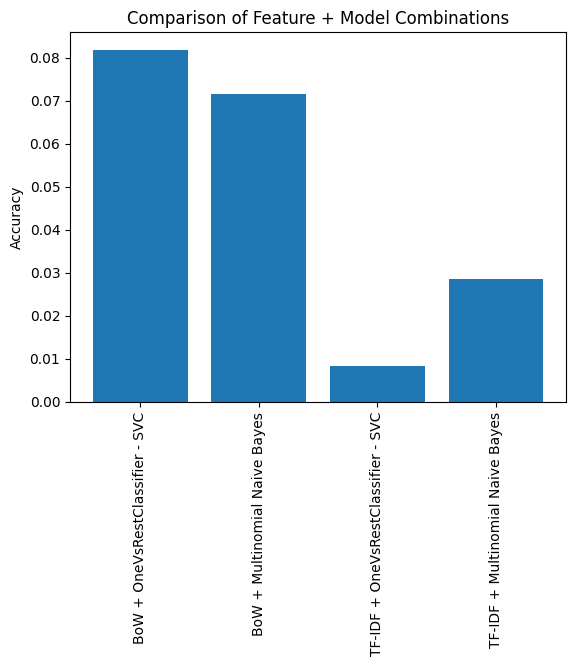

In [56]:
plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy")
plt.title("Comparison of Feature + Model Combinations")
plt.xticks(rotation=90)
plt.show()